# Cahn-Hilliard Equation & Spinodal Decomposition Simulation
Stefan Bringuier, stefanbringuier@gmail.com

In [1]:
#Julia Packages
using Printf;
using Plots;
pyplot();

## Cahn-Hilliard - Part 1

The Cahn-Hillard model was developed from a phase-separation model focused on spinodal decomposition of a binary alloy. Spinodal decomposition is the process whereby chemical species will move against a compositional gradient. The process is not driven by nucleation and growth process, just diffusion.

The characteristic free-energy functional for spinodial decomposition is:

$$ F = \int_{V} \left[ f(c) + \frac{1}{2} \kappa \left(\nabla c\right)^2 \right] dv $$

where $\kappa$ is the gradient energy penalty coefficient and $f(c)$ is the chemical/bulk free energy density represented by:

$$f(c) = Ac^2(1-c)^2$$

This is a simple-double well potential as plotted below ($f(c)$ is intentially bounded between $0<f(c)<1$). Here $A$ is a positive constant that controls the magnitude of the well-barrier. Other free energy potentials are:

$$ f(c) = \frac{1}{4}A\left(1-c^2\right)^2$$

$$ f(c) = 4A\left(-\frac{1}{2}c^2 + \frac{1}{4}c^4\right) $$

### Potential-Well Examples

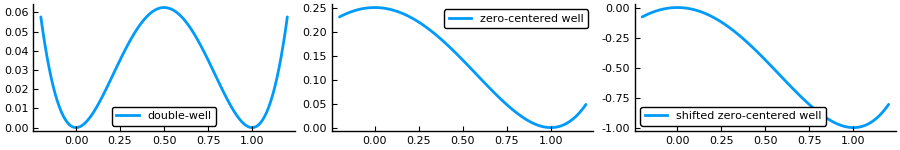

In [2]:
A=1.00e0
f(c)=A*(c^2)*((1-c)^2)
f1(c)=0.25e0*A*(1-c^2)*(1-c^2)
f2(c)=4.00e0*A*(-0.5e0*c^2 + 0.25e0*c^4)
conc = range(-0.20e0,stop=1.20e0,length=120)

dw1 = plot(conc,map(f,conc),label="double-well")
dw2 = plot(conc,map(f1,conc),label="zero-centered well")
dw3 = plot(conc,map(f2,conc),label="shifted zero-centered well")
plot(dw1,dw2,dw3,linewidth=2,size = (900,150),layout=(1,3),
grid=false)

The Cahn-Hillard equation is given by:

$$\frac{\partial c}{\partial t} = \nabla^2 M \left( \frac{\delta F_{ij}}{\delta c} \right) $$

Here $M$ is the mobility and $\frac{\delta F_{ij}}{\delta c}$ is the variational derivative of the free energy functional.

Let us first express the left-hand side of the equation in terms of Explicit Euler time integration:

$$\frac{c_{ij}^{n+1}-c_{ij}^{n}}{\Delta t} = \nabla^2 M \left( \frac{\delta F_{ij}}{\delta c} \right)^n $$

$n$ is the current time interval/step.

The variational derivative of $\frac{\delta F_{ij}}{\delta c}$ is given by:

$$\frac{\delta F_{ij}}{\delta c}^{n} = \mu\left(c_{ij}^n\right) - \kappa \nabla^2 c_{ij}^{n}$$

where $\mu(c_{ij}^{n})$ is the variational derivative of the chemical/bulk free energy and is:

$$ \mu(c_{ij}^{n}) = A\left(2c_{ij}^{n}\left(1-c_{ij}^{n}\right)^{2} + 2\left(c_{ij}^{n}\right)^{2}\left(c_{ij}^{n}-1\right)\right)$$

The laplacian operator in the Cahn-Hillard equation can be approximated by the finite-difference 5-point stencil:

![alt text][stencil]
[stencil]:/Users/bringuiers/Documents/ResearchResources/ExtractedFigures/Figure4.1_ProgrammingPhaseField_1ed.png

The discrete energy functional is written as:

$$F_{bulk} = \sum_i^{Nx} \sum_j^{Ny} f(c_{ij}) = Ac_{ij}^2(1-c_{ij})^2$$
$$F_{grad} = \frac{\kappa}{2} \sum_i^{Nx-1} \sum_j^{Ny-1} \left( \left(c_{i+1,j} - c_{ij}\right)^2 + \left(c_{i,j+1}-c_{ij}\right)^2\right)$$
$$F_D = F_{bulk} + F_{grad}$$

Here $F_{grad}$ is calculated using the spatial forward  discrete difference.

A useful tool is to establish non-dimensional characteristic quantities.

For length we can use the ratio of the gradient energy penalty(e.g. J/m$^3$) to the free energy barrier (e.g. J) and then account for the 2D simulation, thus:

$$L^{\prime} = \left(\frac{\kappa}{A}\right)^{\frac{1}{2}}  \text{[Length]}$$

The same can be done for other quantities:

$$F^{\prime} = AL^3   \text{[Energy-Length^3]}$$

$$t^{\prime} = \frac{L^{\prime 2}\left(c_p^e - c_m^e \right)}{MF^{\prime}} \text{[Time-Mass / Energy-Length]}$$

here $c_p^e$ and $c_m^e$ are the equilibrium concentration of the two phases.

For these simulations the nondimensional time increment was 0.01 with a Euler time integration scheme.

Total number of timesteps is 20,000.


# Cahn-Hilliard Finite-Difference Code

### Data Types
Lets first create Julia composite data types that will be useful. We will need a data type that specifies our spatial grid, ```Spatial2D```, a datatype for the concentration field, ```Conc2D```, a simulation time data type,```Time```, and a data type ```Material``` specifying the material parameters.


#### Notes
For Julia data types and function names I will use "CamelCaps" even though this is not a suggested julia style guide.

In [3]:
# Number of grid points, spacing size, and grid area
struct Spatial2D
    nx::Int64;
    ny::Int64;
    dx::Float64;
    dy::Float64;
    size::Int64;
    cellarea::Float64;
    area::Float64;
    function Spatial2D(nx,ny,dx,dy)
        grid = nx*ny;
        cell = dx*dy;
        area =(dx*nx)*(dy*ny);
        new(nx,ny,dx,dy,grid,cell,area);
    end
end

#Material parameters
struct Material
    avg_c::Float64;    #average concentration
    mobile::Float64;   #Cahn-Hillard mobility coefficient
    grad_pen::Float64; #Gradient penality coefficent
    pote::Float64;  #Potential well energy barrider
    Material(i,m,g,p) = new(i,m,g,p)
end

struct Field2D
    spatial::Spatial2D #Store spatial info
    material::Material #Store material parameters
    field::Array;
    grad::Array;
    laplacian::Array;
    function Field2D(s2D::Spatial2D,mat::Material)
        nx,ny = s2D.nx,s2D.ny;
        c=zeros(s2D.nx,s2D.ny);
        g=zeros(s2D.nx,s2D.ny);
        l=zeros(s2D.nx,s2D.ny);
        new(s2D,mat,c,g,l);
    end
end

#Time and screen output values
mutable struct Time
    ntstep::Int64;    #number of timesteps
    prtfreq::Int64;   #print to screen every ntstep
    timestep::Float64;#numerical time step
    tinit::Float64;   #initial simulation time
    Time(nt,pf,ts,ti) = new(nt,pf,ts,ti)
end



## Simulation Setup & Energy Functions

Now that we have the datatypes we need to define the functions which will process and operate on our data types. The first thing we need is a function to generate a initial microstructure. We will call it ```GenMircoStruct2D``` since it will generate a two-dimensional microstructure, the function will use the average concentration field and apply some random noise then return a new concentration field which is of type ```Conc2D```.

In [4]:
"""function GenMicroStruc2D(spatial info, material parameters)
        This function is used to generate a 2D concentration profile.

        Input - spatial2D::Spatial2D datatype see defined datatypes.
                conc2D::Conc2D datatype see defined datatypes.
                material::Material datatype see defined datatypes.

        Output - conc2D::Conc2D datatype with modified conc2D.conc values. See defined datatypes
        
        Used variables:
             avg_c - average concentration
             noise*rand() - random noise added to concentration
"""
function GenMicroStruc2D(spatial2D::Spatial2D,material::Material,noise::Float64)
    conc = Field2D(spatial2D,material)
    for i=1:conc.spatial.nx
        for j=1:conc.spatial.ny
            conc.field[i,j]=conc.material.avg_c + noise*(0.50e0-rand())
        end
    end
    return conc
end; #function GenMicroStruc2D

#### Simulation parameters & microstructure
Now that we have a function to generate an initial microstructure, let us define the simulation details with the data types we created and the ```GenMicroStruct2D``` function. We will plot a contour view of the concentration field.

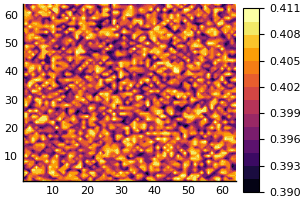

In [5]:
#Initiate simulation parameters
nx,ny = 64,64;
dx,dy = 1.00e0,1.00e0;
spatial = Spatial2D(nx,ny,dx,dy);
steps,prnt,dt,ti = 1000,50,1.00e-2,0.00e0;
time = Time(steps,prnt,dt,ti);
c̄,M,κ,A = 0.40e0,1.00e0,0.50e0,1.00e0;
material = Material(c̄,M,κ,A);
conc = GenMicroStruc2D(spatial,material,0.02e0);
plot(conc.field,st=[:contourf],size=(300,200))

#### Boundary Conditions

Here we will assume periodic boundary conditions, which are simple and straightfoward to implement. To do this we will define a function which takens in the grid location $i,j$ and determine if the points lie on the boundary of the simulation cell. If they do then the index will be shifted. The function is going to be named ```PeriodBoundCond```

In [6]:
""" function PeriodBoundCond(index i,max i)
         This function determines if neighbor indices need to be shifted based on periodic boundary conditions

         Input - i :: Integers  index of a point on 2D grid
                 mi :: Integers max index of the 2D grid

         Output - ni:: Integers unchanged or shifted index
""" function PeriodBoundCond(i::T,mi::T) where T<:Integer
        iplus,iminus = i+1,i-1;
        if iplus > mi 
            iplus = 1;
        elseif iminus == 0
            iminus = mi;
        end
        return (iplus,iminus)
end; # function PeriodBoundCond

#### Free Energy functions

The next step is to define the total free energy of the system based on our free-energy functional. In this case we use the double-well description to define a function called ```TotalFreeEnergy```. We also need the variational derivative of the functional $\frac{\delta F}{\delta c}$, which is given by the derivative of the integrand. Here I'll define the function ```DervBulkFreeEnergy``` as the derivative at a specific site, $ij$, on the 2D spatial grid

In [7]:
"""function TotalFreeEnergy(concentration field, coefficient for gradient penalty)
        This function calculates the total simulation cell free energy. Assumes standard
        Cahn-Hillard free energy functional given by:
        f(c) + \\frac{1}{2}\\kappa\\left(\\nabla c \\right)^2
        uses forward-differences.

        Input - field::Field2D datatype see defined datatypes.

        Output - free_energy::Real
        
        Question: why don't we include the summation over the discrete volume?

"""
function TotalFreeEnergy(field::Field2D)
    free_energy = 0.00e0;
    for i=1:field.spatial.nx
        iplus, = PeriodBoundCond(i,conc.spatial.nx);
        for j=1:conc.spatial.ny
            jplus, = PeriodBoundCond(j,conc.spatial.nx);
            #Indexing variables
            fij = field.field[i,j];
            fiplus = field.field[iplus,j];
            fjplus = field.field[i,jplus];
            #Energy summation over domain
            enrgy_bulk = fij^2 *(1.00e0-fij)^2;
            enrgy_grad = 0.50e0 * field.material.grad_pen * (fiplus-fij)^2 + (fjplus-fij)^2;
            free_energy = free_energy + enrgy_bulk + enrgy_grad;
        end
    end
    return free_energy
end; #function TotalFreeEnergy

""" δ(derivative of field at (i,j))
        This function calculates the derivative of the bulk free energy for a double-well
        potential given by:

        \\mu(c_{ij}^{n}) = A\\left(2c_{ij}^{n}\\left(1-c_{ij}^{n}\\right)^{2} + 
        2\\left(c_{ij}^{n}\\right)^{2}\\left(c_{ij}^{n}-1\\right)\\right)

        Input - f ::Float64 value for the field at i,j.

        Output - Real value for derivative of bulk free energy at i,j

""" δij(f::Float64) = 2.00e0 * f * (1.00e0-f)^2 - 2.00e0 * f^2 * (1.00e0-f);

## Define Laplacian and concentration derivative functions

We now need to do a few things to evolve the spatial and concentration derivatives. The first thing we need to define a function which takes the Laplacian of a field, in this case the field is the concentration. Let us call this function $\nabla^{2}$ The second thing needed is a routine to calculate the variation derivative of the free-energy with respect to concentration, this funciton will be $\delta F!$. Note that the function modifies the conc arguement and returns a free-energy derivative at every point.

In [8]:
""" function δF!(field to take central difference laplacian of)
                 Input - field :: Contains 2D Array of field to take laplacian of

                 Output - dFdc :: Array of variational derivative of Free-energy on
                                  spatial domain grid.
""" function δF!(field::Field2D)
        nx,ny = field.spatial.nx,field.spatial.ny;
        dx,dy = field.spatial.dx,field.spatial.dy;
        #Array for variational derivative dF/dc (derivative of integrand)
        dFdf = zeros(Float64,nx,ny);
    
        #Solve for δF/δf
        for i=1:nx
        iplus,iminus = PeriodBoundCond(i,nx)
        ii = (iminus,i,iplus);
            for j=1:spatial.ny
                jplus,jminus = PeriodBoundCond(j,ny)
                jj = (jminus,j,jplus);
        
                #Calculate the free energy $\frac{\delta F}{\delta c_{ij}}$
                field.laplacian[i,j] = ∇²(ii,jj,dx,dy,field.field)
            
                #Calculate the bulk free energy derivative in free energy expression
                barrier = field.material.pote;
                dfengry_dfij = barrier*δij(field.field[i,j]);
            
                #Store the variational free energy derivative, 
                # e.g. dF/dcij in right-hand side of Cahn-Hillard eq.
                dFdf[i,j] = dfengry_dfij - field.material.grad_pen * field.laplacian[i,j]          
            end
        end
        return dFdf
end;# function δF!

""" function Laplacian2D(indices for i, indices for j,
                         x discrete distance, y discrete distance,
                         field to take Laplacian of)
                 Take central difference laplacian of a field

                 Input - i,j :: Tuple of integer indice about point on 2D grid
                         dx,dy :: discrete spatial spacing between grid points
                         field :: 2D Array of field to take laplacian of

                 Output - ∇²f::Laplacian at point i,j of field
""" function ∇²(i::Tuple{T,T,T},j::Tuple{T,T,T},
                dx::S,dy::S,
                field::Array{S,2}) where {T<:Integer,S<:Real}
               
                #i[1] = i-1, i[2] = i, i[3]= i+1
                ∇²f = (field[i[1],j[2]] + field[i[3],j[2]] + 
                field[i[2],j[1]] + field[i[2],j[3]] - 
                4.00e0 * field[i[2],j[2]]) / (dx*dy);
                
                return ∇²f
end; #function ∇²

## Spatial Solution to R.H.S of Cahn-Hilliard Equation

Now we want to bring things together by solving for the  $\nabla M\left(\frac{\delta F}{\delta c}\right)$. In this notebook, the material mobility interface parameter is constant so the solution is simplified by taking the Laplacian of the variational term. We will define a function similar to $\delta F!$ that does this for us.

In [9]:
""" 

""" function ∇²δF(spatial::Spatial2D,
                 dFdf::Array{T,2}) where T<:Real
    
       nx,ny = spatial.nx,spatial.ny;
       dx,dy = spatial.dx,spatial.dy;
       ∇²dFdf = zeros(Float64,nx,ny);
    
       #Solve for laplacian R.H.S. of Cahn-Hillard eq.:
       #$\nabla^{2}\left(\frac{\delta F}{\delta c_{ij}}\right)$
        for i=1:nx
        iplus,iminus = PeriodBoundCond(i,nx)
        ii = (iminus,i,iplus);
        for j=1:ny
           jplus,jminus = PeriodBoundCond(j,ny)
           jj = (jminus,j,jplus);
           ∇²dFdf[i,j] = ∇²(ii,jj,dx,dy,dFdf);
        end
    end
    return ∇²dFdf
end; #function ∇²δF            

## Time evolution function and Run Simulation

With the neccessary spatial and field derivative functions defined that make up the right hand side of the Cahn-Hillard Equation, we can perform numerical integration to time evolve and find the solution of the concentration field at time, $t$, given our initial conditions (e.g., random distribution of concentration) and boundary condtions (e.g., periodic). The function to do this will be called ```TimeEvolveCH!``` and will take in the ```Time``` and ```Field2D``` datatypes.

In [10]:
function SimInfo(istep::Integer,energy::Float64,
                 time::Time,field::Field2D;skip=true)
    if skip == true
        return 0.00e0
    else
        #We want to confirm total energy is conserved.
        ΔE = (ototalenergy-TotalFreeEnergy(field)) 
        if  abs(ΔE) > tole
            @warn "Change in total energy is $(ΔE)"
        end
        energy = TotalFreeEnergy(field);
            
        if (mod(istep,time.prtfreq) == 0) || (istep == 1)
            @printf("%5d %14.6e\n",istep*Δt,totalenergy)
        end
        
        return energy
    end
end

""" function TimeEvolveCH(simulation time parameters,
                          field to be evolved under C-H equation)

             Input - time::Time simulation time info.
                     field::Field2D field to evolve under C-H eq.

             Output - None                    
""" function TimeEvolveCH!(time::Time,field::Field2D;tole=1.0e-1)
        
        curtime = time.tinit;
        M=field.material.mobile;
        Δt=time.timestep;
        energy = TotalFreeEnergy(field);
    
        for istep=1:time.ntstep
            curtime += time.timestep;
        
            #Physics
            δFδf = δF!(field);
            ∇²δFδf = ∇²δF(field.spatial,δFδf);
            field.field[:,:] += Δt * M * ∇²δFδf[:,:]; #Integrate CH eq.

                    
            #Simulation checks
            energy = SimInfo(istep,energy,time,field);
          
        end
    
        time.tinit = curtime;
end; #function TimeEvolveCH!                

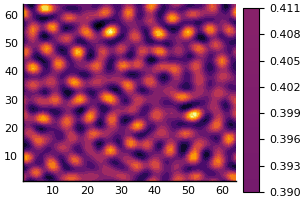

In [11]:
TimeEvolveCH!(time,conc)
plot!(conc.field,st=[:contourf],size=(300,200))

## Run for longer time 
We can see the continued effect of coarsening by running for longer simulations times.

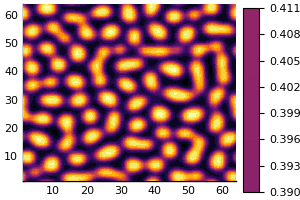

In [12]:
time.ntstep = 1000
TimeEvolveCH!(time,conc)
plot!(conc.field,st=[:contourf],size=(300,200))

Lets run for longer once again.

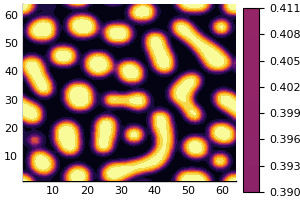

In [13]:
time.ntstep = 8000
TimeEvolveCH!(time,conc)
plot!(conc.field,st=[:contourf],size=(300,200))

##### Potential Issues

There is some difference in the total free energy as a function of time, this only occurs in the initial stages and then decays. The spinodal coarsening seems to be acurately captured.